# Text clustering: HDBSCAN is probably all you need

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/notebooks/stable-diffusion-prompts-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Sections

1. Setup
2. Data I/O
3. Embed text
4. Clustering
5. Exemplar sub-clustering
6. Knowledge graph theming
7. Write final df results to disk
8. Create a JSON knowledge graph viz

## Setup

In [1]:
# copying larger files to GDrive storage for this experiment

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!git clone https://github.com/daniel-furman/awesome-chatgpt-prompts-clustering.git

Cloning into 'awesome-chatgpt-prompts-clustering'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 409 (delta 23), reused 30 (delta 13), pack-reused 369
Receiving objects: 100% (409/409), 4.77 MiB | 30.90 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [3]:
# for local run, see below commands for setting up a new venv

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [4]:
import os

os.chdir("/content/awesome-chatgpt-prompts-clustering")
!ls

experiments  LICENSE  notebooks  README.md  requirements.txt


In [ ]:
!pip install -qUr requirements.txt

In [6]:
os.chdir("../..")
!ls

bin			    etc     media		      root  tools
boot			    home    mnt			      run   usr
content			    lib     NGC-DL-CONTAINER-LICENSE  sbin  var
cuda-keyring_1.0-1_all.deb  lib32   opt			      srv
datalab			    lib64   proc		      sys
dev			    libx32  python-apt		      tmp


In [7]:
#!pip list

In [8]:
import argparse
from tqdm.notebook import tqdm
import datetime
import os
import pickle
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import umap
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import hdbscan
from sklearn.metrics.pairwise import euclidean_distances
import openai
from UliPlot.XLSX import auto_adjust_xlsx_column_width

In [9]:
args = argparse.Namespace()
args.inference = True
args

Namespace(inference=True)

In [10]:
now = datetime.datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

# hardcode in an existing experiment datetime for inference runs

if args.inference:
    # dt_string identifiers from cached experiments:
    dt_string = "04_09_2023_03_02_25"

print("experiment's datetime identifier =", dt_string)

# create results folder if it doesn't exist
if not os.path.isdir(
    f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
):
    os.mkdir(
        f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
    )

experiment's datetime identifier = 04_09_2023_03_02_25


In [11]:
args.cache_folder = (
    f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
)
args

Namespace(inference=True, cache_folder='/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25')

## Data I/O

In [12]:
ds_hf = load_dataset("Gustavosta/Stable-Diffusion-Prompts")
ds = ds_hf["train"]

ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "Prompt"]]
ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

id                                             Prompt
0          0  realistic car 3 d render sci - fi car and sci ...
1          1  a comic potrait of a female necromamcer with b...
2          2  steampunk market interior, colorful, 3 d scene...
3          3  “A portrait of a cyborg in a golden suit, D&D ...
4          4  A full portrait of a beautiful post apocalypti...
...      ...                                                ...
73713  73713  ismail inceoglu epic oil on canvas painting of...
73714  73714  eating crayons and being reborn in the loving ...
73715  73715  ilya kuvshinov with long hair, sky blue hair, ...
73716  73716  cyberpunk woman with green hair wearing futuri...
73717  73717  zulu cyborg, male, green eyes, red diodes, sci...

[73718 rows x 2 columns]

## Embed Text

* See [pretrained models](https://www.sbert.net/docs/pretrained_models.html) for supporting information

In [13]:
model = SentenceTransformer("all-mpnet-base-v2")

In [14]:
if not args.inference:
    embeddings = torch.zeros([len(ds), 768])
    for i in tqdm(range(len(ds))):
        emb = model.encode(ds.loc[i, "Prompt"], convert_to_tensor=True)
        embeddings[i, :] = emb
    embeddings

In [15]:
f_name = os.path.join(
    args.cache_folder, "stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt"
)
print(f_name, "\n")

if not args.inference:
    torch.save(embeddings, f_name)
loaded_embeddings = torch.load(f_name)
loaded_embeddings

/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt 



tensor([[ 0.0128, -0.0047,  0.0303,  ..., -0.0206, -0.0175, -0.0224],
        [ 0.0778,  0.0241,  0.0107,  ...,  0.0214, -0.0264, -0.0066],
        [-0.0083, -0.0285, -0.0183,  ...,  0.0044, -0.0617, -0.0178],
        ...,
        [ 0.0703, -0.0049, -0.0027,  ..., -0.0032, -0.0123, -0.0346],
        [ 0.0472,  0.0163, -0.0073,  ...,  0.0113, -0.0390, -0.0284],
        [ 0.0670,  0.0163, -0.0223,  ...,  0.0428, -0.0363, -0.0268]])

In [16]:
loaded_embeddings.shape

torch.Size([73718, 768])

In [17]:
if not args.inference:
    torch.equal(loaded_embeddings.cpu(), embeddings.cpu())

In [18]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

30687

In [19]:
# test embeddings worked
ds.loc[test_itr, "Prompt"]

'cowboy with a katana striking an action pose, old, white beard, wrinkles, handsome, action pose, katana, profile, intricate, detailed, volumetric lighting, scenery, digital painting, highly detailed, artstation, sharp focus, illustration, concept art, ruan jia, steve mccurry'

In [20]:
test_emb = model.encode(ds.loc[test_itr, "Prompt"], convert_to_tensor=True)
a = np.array(test_emb.cpu())
b = np.array(loaded_embeddings[test_itr, :].cpu())
np.allclose(a, b, rtol=1e-02)

True

## Clustering

* See [how hdbscan works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) for supporting information

In [21]:
# second, perform clustering

# first, perform dimensionality reduction from 768 to 15
f_name = os.path.join(args.cache_folder, "reducer_umap_15.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_15 = umap.UMAP(n_components=15)
    reducer_15.fit(loaded_embeddings)
    embeddings_umap_dim_15 = reducer_15.transform(loaded_embeddings)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_15 == reducer_15.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_15, open(f_name, "wb"))

loaded_reducer_15 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_15 = loaded_reducer_15.transform(loaded_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_15 == loaded_reducer_15.embedding_)

print(embeddings_umap_dim_15.shape)

f_name = os.path.join(args.cache_folder, "clusterer_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=110, gen_min_span_tree=True)
    clusterer.fit(embeddings_umap_dim_15)
    pickle.dump(clusterer, open(f_name, "wb"))

loaded_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.labels_).value_counts(),
            pd.Series(loaded_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.probabilities_).value_counts(),
            pd.Series(loaded_clusterer.probabilities_).value_counts(),
        )
    )

num_ouliers = pd.Series(loaded_clusterer.labels_).value_counts().loc[-1]

print(pd.Series(loaded_clusterer.labels_).value_counts())
print(f"\nCluster outliers : {num_ouliers}\n")

/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/reducer_umap_15.pkl 

(73718, 15)
/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/clusterer_hdbscan.pkl 

-1     48699
 56     2530
 13     1343
 61     1287
 50     1055
       ...  
 15      119
 32      116
 69      112
 12      111
 65      111
Name: count, Length: 79, dtype: int64

Cluster outliers : 48699



In [22]:
ds["cluster"] = loaded_clusterer.labels_
ds["cluster membership prob"] = loaded_clusterer.probabilities_
ds

id                                             Prompt  cluster  \
0          0  realistic car 3 d render sci - fi car and sci ...       52   
1          1  a comic potrait of a female necromamcer with b...       51   
2          2  steampunk market interior, colorful, 3 d scene...       -1   
3          3  “A portrait of a cyborg in a golden suit, D&D ...       31   
4          4  A full portrait of a beautiful post apocalypti...       -1   
...      ...                                                ...      ...   
73713  73713  ismail inceoglu epic oil on canvas painting of...       -1   
73714  73714  eating crayons and being reborn in the loving ...       -1   
73715  73715  ilya kuvshinov with long hair, sky blue hair, ...       -1   
73716  73716  cyberpunk woman with green hair wearing futuri...       -1   
73717  73717  zulu cyborg, male, green eyes, red diodes, sci...       31   

       cluster membership prob  
0                     1.000000  
1                     0.361015  
2                     0.000000  
3                     0.887642  
4                     0.000000  
...                        ...  
73713                 0.000000  
73714                 0.000000  
73715                 0.000000  
73716                 0.000000  
73717                 0.979121  

[73718 rows x 4 columns]

<Axes: ylabel='$\\lambda$ value'>

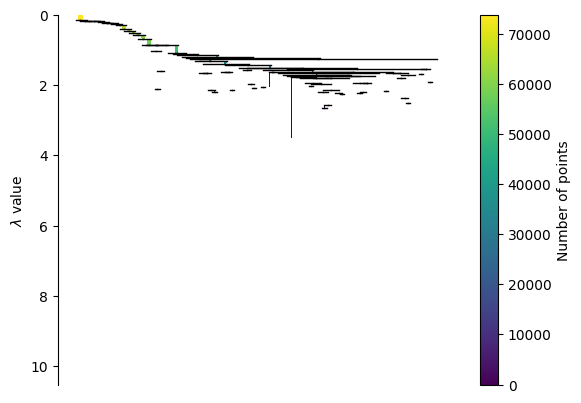

In [23]:
loaded_clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

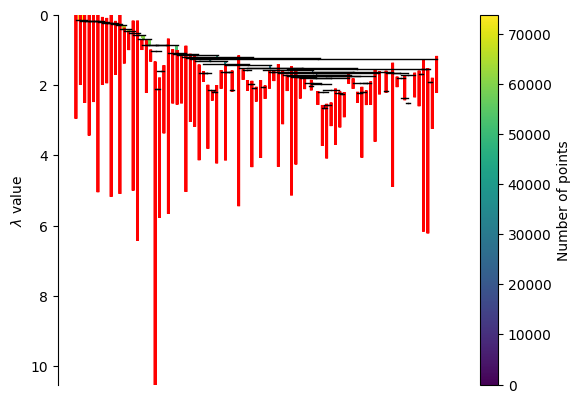

In [24]:
loaded_clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [25]:
# third, perform dimensionality reduction from 15 to 2

f_name = os.path.join(args.cache_folder, "reducer_umap_2.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_2 = umap.UMAP(n_components=2)
    reducer_2.fit(embeddings_umap_dim_15)
    embeddings_umap_dim_2 = reducer_2.transform(embeddings_umap_dim_15)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_2 == reducer_2.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_2, open(f_name, "wb"))

loaded_reducer_2 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_2 = loaded_reducer_2.transform(embeddings_umap_dim_15)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_2 == loaded_reducer_2.embedding_)
embeddings_umap_dim_2.shape

/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/reducer_umap_2.pkl 



(73718, 2)

In [26]:
ds["x"] = embeddings_umap_dim_2[:, 0]
ds["y"] = embeddings_umap_dim_2[:, 1]

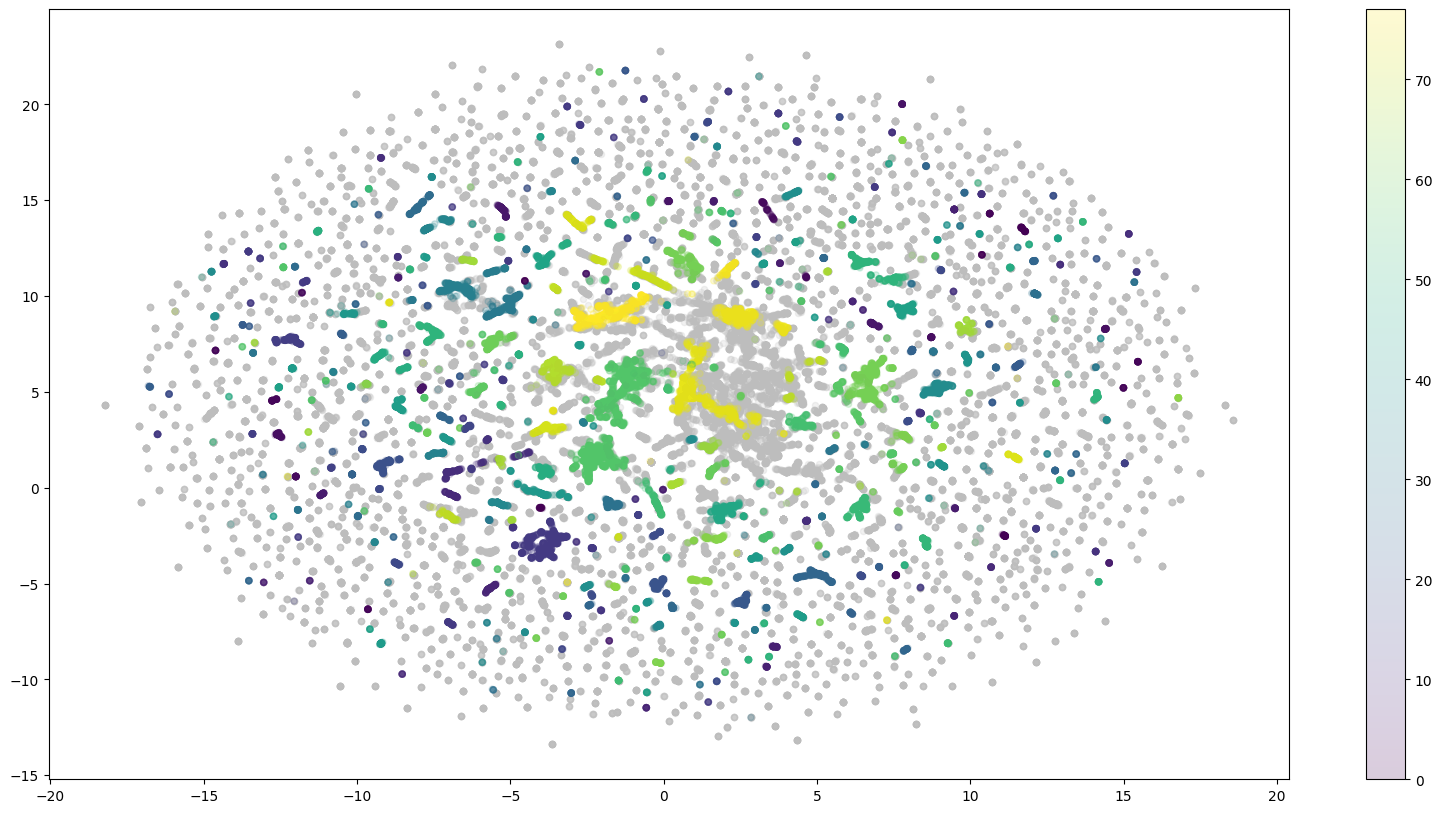

In [110]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = ds[ds["cluster"] == -1]
clustered = ds[ds["cluster"] != -1]
plt.scatter(outliers.x, outliers.y, color="#BDBDBD", s=20, alpha=0.2)
plt.scatter(
    clustered.x, clustered.y, c=clustered.cluster, s=20, alpha=0.2, cmap="viridis"
)
plt.colorbar()

In [27]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["cluster"] != -1],
        y=ds["y"][ds["cluster"] != -1],
        mode="markers",
        marker_color=ds["cluster"][ds["cluster"] != -1],
        marker_colorscale="Viridis",
        text=ds["cluster"][ds["cluster"] != -1],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Exemplar Sub-Clustering

* See [soft clustering explanation](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html) for supporting information

In [28]:
# function copied from:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [29]:
tree = loaded_clusterer.condensed_tree_

exemplar_ids = []
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    print(f"Cluster {i} has {len(c_exemplars)} exemplars")
    exemplar_ids.extend(c_exemplars)

Cluster 0 has 110 exemplars
Cluster 1 has 110 exemplars
Cluster 2 has 110 exemplars
Cluster 3 has 110 exemplars
Cluster 4 has 110 exemplars
Cluster 5 has 110 exemplars
Cluster 6 has 110 exemplars
Cluster 7 has 110 exemplars
Cluster 8 has 110 exemplars
Cluster 9 has 110 exemplars
Cluster 10 has 110 exemplars
Cluster 11 has 110 exemplars
Cluster 12 has 111 exemplars
Cluster 13 has 110 exemplars
Cluster 14 has 110 exemplars
Cluster 15 has 110 exemplars
Cluster 16 has 110 exemplars
Cluster 17 has 110 exemplars
Cluster 18 has 110 exemplars
Cluster 19 has 110 exemplars
Cluster 20 has 110 exemplars
Cluster 21 has 110 exemplars
Cluster 22 has 110 exemplars
Cluster 23 has 110 exemplars
Cluster 24 has 110 exemplars
Cluster 25 has 110 exemplars
Cluster 26 has 110 exemplars
Cluster 27 has 110 exemplars
Cluster 28 has 110 exemplars
Cluster 29 has 110 exemplars
Cluster 30 has 110 exemplars
Cluster 31 has 110 exemplars
Cluster 32 has 110 exemplars
Cluster 33 has 110 exemplars
Cluster 34 has 110 exemp

<ipython-input-28-808adb6f118c>:19: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [30]:
ds["exemplars yes/no"] = np.zeros(len(ds))
ds.loc[exemplar_ids, "exemplars yes/no"] = 1

assert len(ds[ds["exemplars yes/no"] == 1]) == len(exemplar_ids)

In [32]:
print("\n")
fig = go.Figure()

custom_scale = [
    "#949494",  # Gray
    "#F65314",  # Google Red
    "#4285F4",  # Google Blue
]

fig.add_trace(
    go.Scatter(
        x=ds["x"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
        y=ds["y"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 1],
        y=ds["y"][ds["exemplars yes/no"] == 1],
        mode="markers",
        marker_color=ds["cluster"][ds["exemplars yes/no"] == 1],
        marker_colorscale="Viridis",
        text=ds["cluster"][ds["exemplars yes/no"] == 1],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [33]:
len(ds.loc[exemplar_ids])

9131

In [34]:
embeddings_umap_dim_15[exemplar_ids].shape

(9131, 15)

In [35]:
# fourth, perform exemplar sub-clustering

f_name = os.path.join(args.cache_folder, "clusterer_subs_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    sub_clusterer.fit(embeddings_umap_dim_15[exemplar_ids])
    pickle.dump(sub_clusterer, open(f_name, "wb"))

loaded_sub_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.labels_).value_counts(),
            pd.Series(loaded_sub_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.probabilities_).value_counts(),
            pd.Series(loaded_sub_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_sub_clusterer.labels_).value_counts()

/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/clusterer_subs_hdbscan.pkl 


Cluster value counts:



-1      924
 151    110
 87     110
 82     110
 81     110
       ... 
 37       5
 204      4
 220      4
 143      4
 238      4
Name: count, Length: 266, dtype: int64

In [36]:
loaded_sub_clusterer.labels_

array([  1,  12,   1, ..., 151, 151, 151])

In [37]:
ds["exemplar sub-cluster"] = np.repeat(np.nan, len(ds))
ds["cluster XX.YY"] = np.repeat(np.nan, len(ds))
# ds.loc[exemplar_ids] = loaded_sub_clusterer.labels_
ds
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "exemplar sub-cluster"] = loaded_sub_clusterer.labels_[i]
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY"] = (
        "Cluster "
        + str(row.cluster)
        + ", Sub-Cluster "
        + str(int(row["exemplar sub-cluster"]))
    )

# ds.loc[exemplar_ids]
# ds

<ipython-input-37-587ccd6b85dd>:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [38]:
ds_inner_exemplars = ds[ds["exemplars yes/no"] == 1]
ds_inner_exemplars = ds_inner_exemplars[
    ds_inner_exemplars["exemplar sub-cluster"] != -1
]
len(ds_inner_exemplars)

8207

In [39]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
        y=ds["y"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster XX.YY"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] != -1)],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds_inner_exemplars["x"],
        y=ds_inner_exemplars["y"],
        mode="markers",
        marker_color=ds_inner_exemplars["exemplar sub-cluster"],
        marker_colorscale="Viridis",
        text=ds_inner_exemplars["cluster XX.YY"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [61]:
clust_to_zoom = 50

In [62]:
ds_inner_exemplars = ds[
    (ds["exemplars yes/no"] == 1) & (ds["cluster"] == clust_to_zoom)
]
ds_inner_exemplars = ds_inner_exemplars[
    ds_inner_exemplars["exemplar sub-cluster"] != -1
]
len(ds_inner_exemplars)

195

In [63]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] == clust_to_zoom)],
        y=ds["y"][(ds["exemplars yes/no"] == 0) & (ds["cluster"] == clust_to_zoom)],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster XX.YY"][
            (ds["exemplars yes/no"] == 0) & (ds["cluster"] == clust_to_zoom)
        ],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds_inner_exemplars["x"],
        y=ds_inner_exemplars["y"],
        mode="markers",
        marker_color=ds_inner_exemplars["exemplar sub-cluster"],
        marker_colorscale="Viridis",
        text=ds_inner_exemplars["cluster XX.YY"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [64]:
print(pd.Series(loaded_clusterer.labels_).value_counts().iloc[0:10])

-1     48699
 56     2530
 13     1343
 61     1287
 50     1055
 74      749
 77      714
 25      654
 31      578
 44      493
Name: count, dtype: int64


## Create summary themes knowledge graph

In [67]:
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.Model.list()

In [68]:
gpt_prompt = "Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding."

summaries = []

for sub_clust in np.unique(np.array(ds[ds["exemplars yes/no"] == 1]["cluster XX.YY"])):
    # gpt_prompt = "Please identify the core theme among the given prompts. The response cannot be longer than 1 sentence."

    sub_df = ds[ds["cluster XX.YY"] == sub_clust]
    if sub_df["cluster"].iloc[0] == clust_to_zoom:
        sub_prompts = sub_df["Prompt"].astype(str)
        sub_prompts = sub_prompts.reset_index(drop=True)

        # sub_prompts = "Task: " + sub_df["act"].astype(str) + ". Prompt: " + sub_df["prompt"].astype(str)

        # sub_clust = sub_clust.split(", ")[-1]
        gpt_prompt += "\n" + sub_clust + ": "
        gpt_prompt += f"\n" + str(sub_prompts) + '"\n'


print(gpt_prompt)

Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding.
Cluster 50, Sub-Cluster -1: 
0     tattooed megan fox wearing a mermeid shell bik...
1     megan fox, d & d, fantasy, portrait, highly de...
2     portrait of megan fox as pirate, scarf, crossb...
3     portrait of megan fox as tron, disney, tron, d...
4     megan fox wearing a shell bikini, atlantis in ...
5     megan fox vampire, perfect face, gold waistcoa...
6     megan fox vampire, perfect face, gold waistcoa...
7     megan fox, d & d, fantasy, portrait, highly de...
8     closeup dream photo of a beautiful megan fox w...
9     portrait of megan fox as vampire queen, bats, ...
10    megan fox in the style of final fantasy 7 by a...
11    portrait of megan fox, muscular upper body, bi...
12    megan fox as a beautiful tattooed female maid ...
13    p

In [69]:
MODEL = "gpt-3.5-turbo-16k"
full_dict_response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": gpt_prompt},
    ],
    temperature=0,
)

text_generation = full_dict_response["choices"][0]["message"]["content"]

print(text_generation)

Cluster 50, Sub-Cluster -1: The core theme for this sub-cluster is "Fantasy Portraits of Megan Fox."

Cluster 50, Sub-Cluster 178: The core theme for this sub-cluster is "Portraits of Megan Fox in Apex Legends."

Cluster 50, Sub-Cluster 186: The core theme for this sub-cluster is "Psychedelic Portraits of Megan Fox as a Soldier."

Cluster 50, Sub-Cluster 187: The core theme for this sub-cluster is "Various Portraits of Megan Fox in Different Styles."

Cluster 50, Sub-Cluster 54: The core theme for this sub-cluster is "Portraits of Emma Watson in Different Styles."

Cluster 50, Sub-Cluster 74: The core theme for this sub-cluster is "Portraits of Megan Fox as Scarlett Witch."


In [70]:
individual_respones = text_generation.split("\n")
individual_respones_formatted = []
for i in individual_respones:
    if len(i) > 0:
        individual_respones_formatted.append(i)

individual_respones_formatted

['Cluster 50, Sub-Cluster -1: The core theme for this sub-cluster is "Fantasy Portraits of Megan Fox."',
 'Cluster 50, Sub-Cluster 178: The core theme for this sub-cluster is "Portraits of Megan Fox in Apex Legends."',
 'Cluster 50, Sub-Cluster 186: The core theme for this sub-cluster is "Psychedelic Portraits of Megan Fox as a Soldier."',
 'Cluster 50, Sub-Cluster 187: The core theme for this sub-cluster is "Various Portraits of Megan Fox in Different Styles."',
 'Cluster 50, Sub-Cluster 54: The core theme for this sub-cluster is "Portraits of Emma Watson in Different Styles."',
 'Cluster 50, Sub-Cluster 74: The core theme for this sub-cluster is "Portraits of Megan Fox as Scarlett Witch."']

In [73]:
summaries_dict = {}

for item in individual_respones_formatted:
    content = item.split(": ")[-1]
    sub_clust = item.split(":")[0]
    summaries_dict[sub_clust] = content
summaries_dict

{'Cluster 50, Sub-Cluster -1': 'The core theme for this sub-cluster is "Fantasy Portraits of Megan Fox."',
 'Cluster 50, Sub-Cluster 178': 'The core theme for this sub-cluster is "Portraits of Megan Fox in Apex Legends."',
 'Cluster 50, Sub-Cluster 186': 'The core theme for this sub-cluster is "Psychedelic Portraits of Megan Fox as a Soldier."',
 'Cluster 50, Sub-Cluster 187': 'The core theme for this sub-cluster is "Various Portraits of Megan Fox in Different Styles."',
 'Cluster 50, Sub-Cluster 54': 'The core theme for this sub-cluster is "Portraits of Emma Watson in Different Styles."',
 'Cluster 50, Sub-Cluster 74': 'The core theme for this sub-cluster is "Portraits of Megan Fox as Scarlett Witch."'}

## Write final df results to disk

In [79]:
# write final ds to disk
f_name = os.path.join(
    args.cache_folder, "stable_diffusion_prompts_dataframe_cached_with_results.xlsx"
)
print(f_name, "\n")

# re-order cols
ds = ds[
    [
        "id",
        "cluster",
        "x",
        "y",
        "cluster membership prob",
        "exemplars yes/no",
        "exemplar sub-cluster",
        "cluster XX.YY",
        "Prompt",
    ]
]

# write with adjusted col width
# if not args.inference:
if True:
    with pd.ExcelWriter(f_name) as writer:
        ds.to_excel(writer, sheet_name="All Prompts")
        auto_adjust_xlsx_column_width(ds, writer, sheet_name="All Prompts", margin=1)

/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25/stable_diffusion_prompts_dataframe_cached_with_results.xlsx 



## Format a JSON viz graph

In [80]:
args.cache_folder

'/content/drive/MyDrive/colab_files/text_clustering/experiments/04_09_2023_03_02_25'

In [81]:
# optional ds cached loading
ds = pd.read_excel(
    os.path.join(
        args.cache_folder, "stable_diffusion_prompts_dataframe_cached_with_results.xlsx"
    ),
    index_col="Unnamed: 0",
)
ds

id  cluster          x          y  cluster membership prob  \
0          0       52   6.367171  -1.370529                 1.000000   
1          1       51  -0.914971  14.205160                 0.361015   
2          2       -1  -1.574000   8.215963                 0.000000   
3          3       31  -5.293690   9.292396                 0.887642   
4          4       -1  12.724822   2.950573                 0.000000   
...      ...      ...        ...        ...                      ...   
73713  73713       -1  10.263610  -0.206133                 0.000000   
73714  73714       -1   3.630631   6.450800                 0.000000   
73715  73715       -1  16.592136   2.287766                 0.000000   
73716  73716       -1  -1.338233  12.725625                 0.000000   
73717  73717       31  -4.855416   9.951269                 0.979121   

       exemplars yes/no  exemplar sub-cluster               cluster XX.YY  \
0                     1                  84.0  Cluster 52, Sub-Cluster 84   
1                     0                   NaN                         NaN   
2                     0                   NaN                         NaN   
3                     0                   NaN                         NaN   
4                     0                   NaN                         NaN   
...                 ...                   ...                         ...   
73713                 0                   NaN                         NaN   
73714                 0                   NaN                         NaN   
73715                 0                   NaN                         NaN   
73716                 0                   NaN                         NaN   
73717                 0                   NaN                         NaN   

                                                  Prompt  
0      realistic car 3 d render sci - fi car and sci ...  
1      a comic potrait of a female necromamcer with b...  
2      steampunk market interior, colorful, 3 d scene...  
3      “A portrait of a cyborg in a golden suit, D&D ...  
4      A full portrait of a beautiful post apocalypti...  
...                                                  ...  
73713  ismail inceoglu epic oil on canvas painting of...  
73714  eating crayons and being reborn in the loving ...  
73715  ilya kuvshinov with long hair, sky blue hair, ...  
73716  cyberpunk woman with green hair wearing futuri...  
73717  zulu cyborg, male, green eyes, red diodes, sci...  

[73718 rows x 9 columns]

In [94]:
knowledge_graphs = []

ds_clust = ds[(ds["exemplars yes/no"] == 1) & (ds["cluster"] == clust_to_zoom)]
ds_clust

for sub_clust in np.unique(np.array(ds_clust["cluster XX.YY"])):
    prompts = []
    ds_inner = ds_clust[ds_clust["cluster XX.YY"] == sub_clust]
    for i in range(len(ds_inner)):
        row = ds_inner.iloc[i]
        if row["exemplars yes/no"] == 1:
            prompts.append(
                {
                    "Prompt": row.Prompt,
                    "id": float(row["id"]),
                }
            )

    viz = {
        "core theme": summaries_dict[ds_inner.iloc[0]["cluster XX.YY"]]
        .split('"')[-2]
        .split(".")[0],
        "cluster id": ds_inner.iloc[0]["cluster XX.YY"],
        # "frequency": str(np.round(100 * len(ds_inner) / len(ds), 2)) + "%",
        # "count": len(ds_inner),
        "exemplars": prompts,
    }

    knowledge_graphs.append(viz)

In [95]:
import json

for i in range(len(np.unique(np.array(ds_clust["cluster XX.YY"])))):
    sub_clust = np.unique(np.array(ds_clust["cluster XX.YY"]))[i]

    # Serializing json
    json_object = json.dumps(knowledge_graphs[i], indent=4)
    print(json_object)
    print("\n\n")

{
    "core theme": "Fantasy Portraits of Megan Fox",
    "cluster id": "Cluster 50, Sub-Cluster -1",
    "exemplars": [
        {
            "Prompt": "tattooed megan fox wearing a mermeid shell bikini top, atlantis in the background, one eye wink, highly detailed face, realistic face, beautiful detailed eyes, fantasy art, in the style of greg rutkowski, illustration, epic, fantasy, intricate, hyper detailed, artstation, concept art, smooth, sharp focus, ray tracing, vibrant,",
            "id": 12188.0
        },
        {
            "Prompt": "megan fox, d & d, fantasy, portrait, highly detailed, perfect face, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve",
            "id": 14755.0
        },
        {
            "Prompt": "portrait of megan fox as pirate, scarf, crossbones, gold, sails, pirates if the caribbean, intricate, headshot, highly detailed, digital painting, artstation, concept 

## Drift detection on the above cluster

### To come